In [76]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn
seaborn.set()

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/gender_submission.csv
/kaggle/input/titanic/test.csv


# Prepare data - see the "explore" notebook for plots of the data

In [73]:
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")

def process_data(df):
    # Fill in missing ages with the median age of the category the person falls into 
    for i in ["male", "female"]:
        for j in range(0, 3):
            age_fill = df[(df.Sex == i) & (df.Pclass == j+1)]["Age"].dropna()
            df.loc[ (df.Age.isnull()) & (df.Sex == i) & (df.Pclass == j+1), "Age"] = age_fill.median()
    
    # Fill remaining missing
    df.Embarked = df.Embarked.fillna("S")
    df.drop("Cabin", axis=1, inplace=True)

    def find_children(passenger):
        """
        For a given row, return Male/Female/Child.
        """
        if passenger.Age <16:
            return "child"
        else:
            return passenger.Sex
    
    # Person
    df["Person"] = df[["Age","Sex"]].apply(find_children,axis=1)
    
    # Alone
    df["Fam_size"] = df.Parch + df.SibSp
    df["Alone"] = df.Parch + df.SibSp
    df["Alone"].loc[df["Alone"]>0] = "With Family"
    df["Alone"].loc[df["Alone"] == 0] = "Without Family"
    
    # Age_quant
    df["Age_quant"] = pd.qcut(df.Age, 6)
    
    # Fare quant
    df["Fare_quant"] = pd.qcut(df.Fare, 6)
    
    # Title
    df["Title"] = df.Name.str.extract(" ([A-Za-z]+)\.", expand=False)
    
    df["Title"] = df["Title"].replace(["Lady", "Countess","Capt", "Col", "Don", "Dr", "Major", "Rev", "Sir", 
                                       "Jonkheer", "Dona"], "Other")

    df["Title"] = df["Title"].replace("Mlle", "Miss")
    df["Title"] = df["Title"].replace("Ms", "Miss")
    df["Title"] = df["Title"].replace("Mme", "Mrs")
    
    # Family surname- used later to determine if a passenger has family member that survived
    df["Surname"] = df.Name.str.extract("([A-za-z]+)\,", expand=False)
    
    
    
process_data(train_data)
process_data(test_data)
train_data.head()

    
# test_data["Surname_survived"] = test_data.apply(find_surname_survival, axis=1)

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Person,Fam_size,Alone,Age_quant,Fare_quant,Title,Surname
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,male,1,With Family,"(19.0, 24.0]","(-0.001, 7.775]",Mr,Braund
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,female,1,With Family,"(32.5, 40.5]","(52.369, 512.329]",Mrs,Cumings
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S,female,0,Without Family,"(24.0, 26.0]","(7.775, 8.662]",Miss,Heikkinen
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S,female,1,With Family,"(32.5, 40.5]","(52.369, 512.329]",Mrs,Futrelle
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S,male,0,Without Family,"(32.5, 40.5]","(7.775, 8.662]",Mr,Allen


# EXPLORE HYPERPARAMETERS FOR GRADIENT BOOST

In [74]:
# ---- PREPARE DATA
# Split training data for testing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

train_data2, test_data2 = train_test_split(train_data, random_state=0)

# Use this after splitting the training set for model selection
def find_surname_survival(passenger):
    """
    For a given row, return whether any other members of the passengers family survived (known for the training data).
    """
    if train_data2.loc[(train_data2.Surname == passenger.Surname) & (train_data2.Name != passenger.Name), "Survived"].sum() > 0:
        return 1
    else:
        return 0
    

train_data2["Surname_survived"] = train_data2.apply(find_surname_survival, axis=1)
test_data2["Surname_survived"] = test_data2.apply(find_surname_survival, axis=1)

features = ["Pclass", "Person", "Title", "Alone", "Surname_survived", "Embarked", "Age_quant", "Fare_quant"]

# Our matrices for input into the classifier
Xtrain2 = pd.get_dummies(train_data2[features])
ytrain2 = train_data2["Survived"]
Xtest2 = pd.get_dummies(test_data2[features])
ytest2 = test_data2["Survived"]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


/opt/conda/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass param_name=n_estimators, param_range=[ 100  300  500  700  900 1100 1300 1500 1700 1900] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


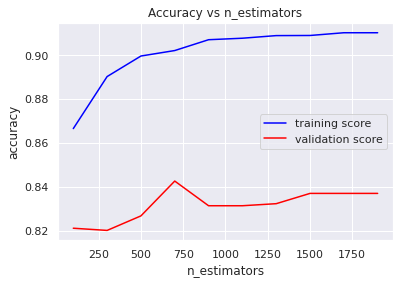

In [86]:
# How many trees?

from sklearn.ensemble import GradientBoostingClassifier

def val_plot(mod, param, param_range):
    val_train, val_test = validation_curve(mod, Xtrain, ytrain, 
                                           param, param_range,
                                           cv=10)
    
    plt.plot(param_range, np.median(val_train, 1), color='blue', label='training score')
    plt.plot(param_range, np.median(val_test, 1), color='red', label='validation score')
    plt.legend(loc='best')
    plt.xlabel(param)
    plt.ylabel("accuracy")
    plt.title("Accuracy vs " + param)
    

n_estimators = np.arange(100,2000,200)
mod = GradientBoostingClassifier()
val_plot(mod, "n_estimators", n_estimators)

In [87]:
# Above plot seems to show the best number of trees is around 500 - 750

from sklearn.ensemble import GradientBoostingClassifier

n_estimators = np.arange(250, 750, 10)
max_depth = np.arange(1,25)
min_samples_split = np.arange(2,35)
learning_rate = np.arange(0.001, 0.0075, 0.0005)
subsample = np.arange(0.05, 1, 0.05)

param_grid = dict(n_estimators = n_estimators, 
                  max_depth = max_depth, 
                  min_samples_split = min_samples_split, 
                  learning_rate= learning_rate,
                  subsample = subsample)

grid1 = RandomizedSearchCV(GradientBoostingClassifier(), param_grid, n_iter=50, cv=10, n_jobs=-1)
grid1.fit(Xtrain2, ytrain2)

y_pred = grid1.best_estimator_.predict(Xtest2)
print(accuracy_score(y_pred, ytest2))

sorted_results = pd.DataFrame(grid1.cv_results_).sort_values(by="rank_test_score")
sorted_results.reset_index(inplace=True)
for i in range(30):
    print(sorted_results.params[i], " ---- ", sorted_results.mean_test_score[i])


0.8385650224215246
{'subsample': 0.2, 'n_estimators': 520, 'min_samples_split': 5, 'max_depth': 22, 'learning_rate': 0.003}  ----  0.8354138398914518
{'subsample': 0.25, 'n_estimators': 560, 'min_samples_split': 10, 'max_depth': 20, 'learning_rate': 0.0065}  ----  0.830958842152872
{'subsample': 0.55, 'n_estimators': 370, 'min_samples_split': 27, 'max_depth': 22, 'learning_rate': 0.0015}  ----  0.8308683853459973
{'subsample': 0.3, 'n_estimators': 410, 'min_samples_split': 29, 'max_depth': 9, 'learning_rate': 0.005}  ----  0.8294210764360017
{'subsample': 0.9500000000000001, 'n_estimators': 340, 'min_samples_split': 6, 'max_depth': 4, 'learning_rate': 0.0065}  ----  0.8293984622342832
{'subsample': 0.25, 'n_estimators': 490, 'min_samples_split': 2, 'max_depth': 23, 'learning_rate': 0.0025}  ----  0.8279511533242877
{'subsample': 0.3, 'n_estimators': 390, 'min_samples_split': 5, 'max_depth': 20, 'learning_rate': 0.003}  ----  0.827928539122569
{'subsample': 0.55, 'n_estimators': 660, 'm

# FIT MODEL FOR SUBMISSION

In [68]:
# ---- Prepare data
# Use this after splitting the training set for model selection
def find_surname_survival(passenger):
    """
    For a given row, return whether any other members of the passengers family survived (known for the training data).
    """
    if train_data.loc[(train_data.Surname == passenger.Surname) & (train_data.Name != passenger.Name), "Survived"].sum() > 0:
        return 1
    else:
        return 0
    

train_data["Surname_survived"] = train_data.apply(find_surname_survival, axis=1)
test_data["Surname_survived"] = test_data.apply(find_surname_survival, axis=1)

features = ["Pclass", "Person", "Title", "Alone", "Fam_size", "Surname_survived", "Embarked", "Age_quant", "Fare_quant"]

Xtrain = pd.get_dummies(train_data[features])
ytrain = train_data["Survived"]

Xtest = pd.get_dummies(test_data[features])


# ---- TUNE UP
n_estimators = np.arange(300, 600, 10)
max_depth = np.arange(5,25)
min_samples_split = np.arange(5,30)
learning_rate = np.arange(0.001, 0.0075, 0.0005)
subsample = np.arange(0.05, 1, 0.05)

param_grid = dict(n_estimators = n_estimators, 
                  max_depth = max_depth, 
                  min_samples_split = min_samples_split, 
                  learning_rate= learning_rate,
                  subsample = subsample)

grid2 = RandomizedSearchCV(GradientBoostingClassifier(), param_grid, n_iter=50, cv=10, n_jobs=-1).fit(Xtrain, ytrain)

print(grid2.best_params_)


# ---- PREDICT
mod_GB = grid2.best_estimator_

predictions = mod_GB.predict(Xtest)

# Output
output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
output.to_csv('my_submission.csv', index=False)
print("Your submission was successfully saved!")